Importing the required libraries

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Reading the images 

Text(0.5, 0, 'Train image (Image to be transformed)')

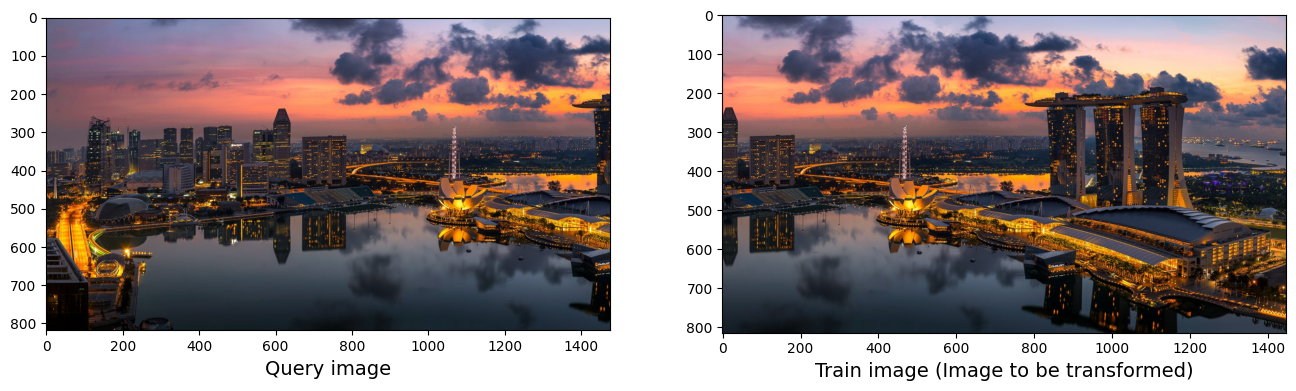

In [7]:
# train image -- image to be transformed
train_photo = cv2.imread('train.jpg')
train_photo = cv2.cvtColor(train_photo,cv2.COLOR_BGR2RGB)
train_photo_gray = cv2.cvtColor(train_photo, cv2.COLOR_RGB2GRAY)    # converting to grayscale

# query image 
query_photo = cv2.imread('query.jpg')
query_photo = cv2.cvtColor(query_photo,cv2.COLOR_BGR2RGB)
query_photo_gray = cv2.cvtColor(query_photo, cv2.COLOR_RGB2GRAY) # converting to grayscale

# plotting the images
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,9))

ax1.imshow(query_photo, cmap="gray")
ax1.set_xlabel("Query image", fontsize=14)

ax2.imshow(train_photo, cmap="gray")
ax2.set_xlabel("Train image (Image to be transformed)", fontsize=14)

Feature Detection and Description
- This method extracts the keypoints and their corresponding feature vectors (descriptors) from an image

In [8]:
def find_keypoints_descriptor(image):    
    
    # creating keypoint descriptor using SIFT 
    descriptor = cv2.SIFT_create() 

    # keypoints -- list of of all the keypints in image
    # features -- numpy array of shape --> (Number of Keypoints)×128 
    # features are a numerical description to the area of the image the keypoint refers to
    (keypoints, features) = descriptor.detectAndCompute(image, None) 
    
    return (keypoints, features)

In [9]:
# Finding the keypoints and feature vectors for Query and Train images

keypoints_query_img, features_query_img = find_keypoints_descriptor(query_photo_gray)
keypoints_train_img, features_train_img = find_keypoints_descriptor(train_photo_gray)

print("Query image Feature Matrix\n", features_query_img)
print("\nTrain image Feature Matrix\n", features_train_img)

print("\nQuery image feature matrix shape: ", features_query_img.shape)
print("\nTrain image feature matrix shape: ", features_train_img.shape)

Query image Feature Matrix
 [[128.  27.  19. ...   8.   1.   7.]
 [  4.   4.   9. ...   0.   0.   1.]
 [  5.   0.   0. ...   0.   0.   1.]
 ...
 [  4.   7.   5. ...   0.   0.   0.]
 [  0.   0.   0. ...   5.   0.   0.]
 [  0.   0.   0. ...   0.   0.  14.]]

Train image Feature Matrix
 [[  1.   3.   2. ...   0.   0.   4.]
 [ 13.   9.   8. ...  12.  12.  25.]
 [  2.   1.   4. ...  59.  12.   1.]
 ...
 [ 18.  38.   5. ...   0.  14.  33.]
 [140.  52.  36. ...   0.   0.   1.]
 [  0.   0.   0. ...   0.   0.   0.]]

Query image feature matrix shape:  (4922, 128)

Train image feature matrix shape:  (6086, 128)


Keypoints 
- Each keypoint is a special structure which has many attributes like its (x,y) coordinates, size of the meaningful neighbourhood, angle which specifies its orientation etc.

In [17]:
# details of the keypoint obtained

for keypoint in keypoints_query_img:
    x,y = keypoint.pt # (x,y) -- position of the keypoint
    size = keypoint.size # diameter of keypoint
    orientation = keypoint.angle # orientation of keypoint
    response = keypoint.response 
    octave = keypoint.octave
    class_id = keypoint.class_id # object id

print (x,y)
print(size)
print(orientation)
print(response)
print(octave)
print(class_id)

features_query_img.shape # feature numpy array size


1472.0048828125 116.56388854980469
2.0020148754119873
98.62557983398438
0.017185334116220474
7864831
-1


(4922, 128)

Text(0.5, 0, '(b)')

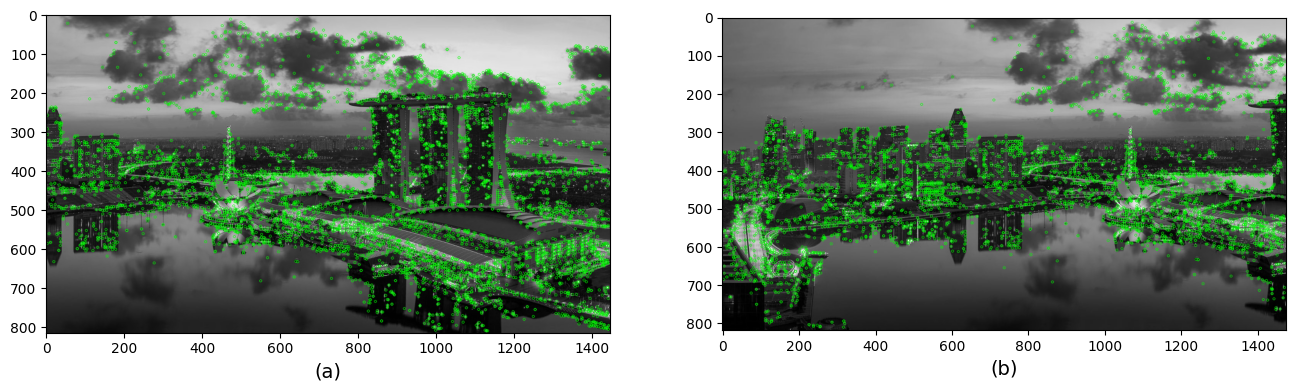

In [11]:
# draw keypoints on the image
fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,9))
ax1.imshow(cv2.drawKeypoints(train_photo_gray, keypoints_train_img, None, color=(0,255,0)))

ax1.set_xlabel("(a)", fontsize=14)

ax2.imshow(cv2.drawKeypoints(query_photo_gray,keypoints_query_img,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)

Feature Matching 
- Matching the descriptors of the two images using BruteForce Matcher

Brute Force Matcher 
- It takes the descriptor of one feature in first set and is matched with all other features in second set using some distance calculation. And the closest one is returned.
- BFMatcher.match()

Raw matches with Brute force): 6086


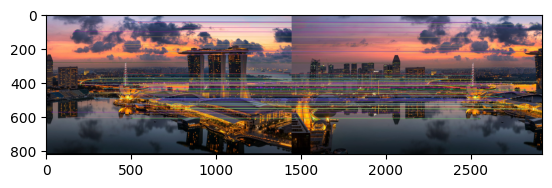

(<matplotlib.image.AxesImage at 0x14f4c8150>, None)

In [12]:
# BFMatcher with default params
bf = cv2.BFMatcher()

# list of matches between keypoints in the training and query images
best_matches = bf.match(features_train_img, features_query_img) 

# sorts the matches based on their distance
rawMatches = sorted(best_matches, key = lambda x:x.distance)
print("Raw matches with Brute force):", len(rawMatches))

# Draw the first 100 matches
img3 = cv2.drawMatches(train_photo,keypoints_train_img,
                       query_photo,keypoints_query_img,
                       rawMatches[:100],
                       None,
                       flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS) 
plt.imshow(img3),plt.show()

#for i in rawMatches:
#    print(i.queryIdx, i.trainIdx, i.distance)

BFMatcher.knnMatch() to get k best matches

Raw matches(knn): 6086


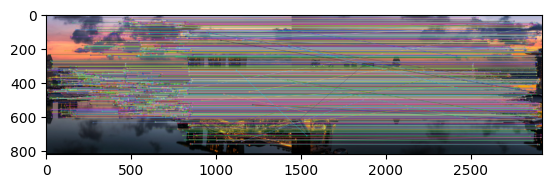

(<matplotlib.image.AxesImage at 0x14f7443d0>, None)

In [13]:
# BFMatcher with default params
bf = cv2.BFMatcher()

# returns k best matches
# list of matches between keypoints in the training and query images
raw_matches = bf.knnMatch(features_train_img, features_query_img, k=2) 
print("Raw matches(knn):", len(raw_matches))

# Apply ratio test
good = [] # actual matches
good_without_list = []

for m,n in raw_matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
        good_without_list.append(m)

# to draw the matches
# cv2.drawMatchesKnn expects list of lists as matches
img3 = cv2.drawMatchesKnn(train_photo,keypoints_train_img,
                          query_photo,keypoints_query_img,
                          good,
                          None,
                          flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)   
plt.imshow(img3),plt.show()


Calculating homography
- This method takes the keypoints and a reprojection threshold as inputs.
- It uses RANSAC Algorithm to compute the best model having maximum number of inliners.

In [14]:
def find_homography(keypoints_train_img,keypoints_query_img, matches, reprojThresh):   
   
    # reprojThresh -- max allowed error in pixel distance to treat keypoint as inlier

    # converting the keypoints to numpy arrays
    keypoints_train_img = np.float32([keypoint.pt for keypoint in keypoints_train_img])
    keypoints_query_img = np.float32([keypoint.pt for keypoint in keypoints_query_img])
    
    if len(matches) > 4:
        # construct the two sets of points
        points_train = np.float32([keypoints_train_img[m.queryIdx] for m in matches]) # Train image matched keypoint's coordinates
        points_query = np.float32([keypoints_query_img[m.trainIdx] for m in matches]) # Query image matched keypoint's coordinates

        
        # Calculate the homography between the sets of points
        # RANSAC -- computes a homography and gives you a prediction for which pairs are inliers and which are outliers
        # H -- homography matrix
        (H, status) = cv2.findHomography(points_train, points_query, cv2.RANSAC, reprojThresh)  

        return (matches, H, status)

    else:
        return None

In [15]:
M = find_homography(keypoints_train_img,keypoints_query_img, rawMatches, reprojThresh=4.0)

if M is None:
    print("Error!")

(rawMatches, Homography_Matrix, status) = M

print("Homography Matrix: \n\n", Homography_Matrix)

Homography Matrix: 

 [[ 1.00010208e+00 -1.40664185e-05  5.99006654e+02]
 [ 2.88388540e-05  1.00005419e+00  2.97899545e+00]
 [ 8.32483394e-08 -5.60862384e-09  1.00000000e+00]]


Image Warping
- Stitching two images to create a panaromic view

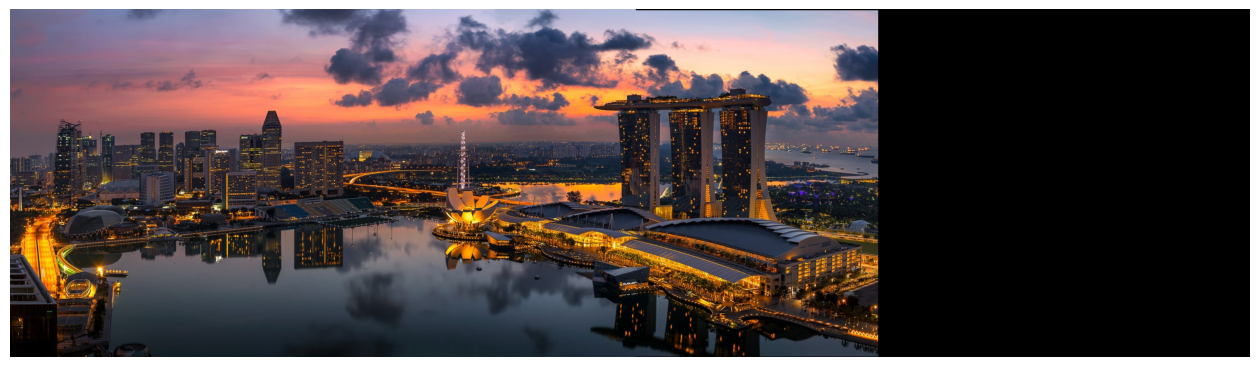

In [16]:
width = query_photo.shape[1] + train_photo.shape[1]
height = max(query_photo.shape[0], train_photo.shape[0])

# The warpPerspective() -- aligns the train image with the query image
#                          returns an image whose size is the same as the size of the original image
# Hence set the pixels as per query_photo
result = cv2.warpPerspective(train_photo, Homography_Matrix, (width, height))

# Check if the result image is valid
if result is not None:

    '''
    combine the query image and the transformed train image 
    by taking the common part and replacing it
    It crops the result image to match the size of the query_photo, creating a region where the query_photo will be placed
    this selected portion is replaced by query image
    '''
    result[0:query_photo.shape[0], 0:query_photo.shape[1]] = query_photo
    

    plt.figure(figsize=(16,9))
    plt.axis('off')
    plt.imshow(result)
   
else:
    print("Error: Unable to stitch images")